In [1]:
! pip install --quiet  matplotlib
! pip3 install --quiet  --upgrade "google-cloud-aiplatform>=1.38"

In [18]:
# Gemini Function

import vertexai
from vertexai.generative_models import GenerativeModel, GenerationConfig, SafetySetting

def generate(text1):
    vertexai.init(project="layo-demo", location="us-central1")
    model = GenerativeModel("gemini-1.5-flash-002")
    
    generation_config = {
        "max_output_tokens": 100,
        "temperature": 0,
        "top_p": 0.95,
        "seed" : 1,
        "response_logprobs": True
    }
    
    safety_settings = [
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
        SafetySetting(
            category=SafetySetting.HarmCategory.HARM_CATEGORY_HARASSMENT,
            threshold=SafetySetting.HarmBlockThreshold.OFF
        ),
    ]

    # Call the model's generate_content function
    response = model.generate_content(
        [text1],
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=False,
    )

    # Extract the text from the response
    final_prompt = response.candidates[0].content.parts[0].text if response.candidates else ""

    return final_prompt

Enter the prompt to create an image, example : 'Create an image for a new coffee shop campaign'  Create an image for a new coffee shop campaign


AI Prompt : Photorealistic image of a bright, modern coffee shop interior, showcasing a steaming cup of coffee on a minimalist table, bathed in warm, natural light.  Focus on the coffee and the inviting atmosphere.



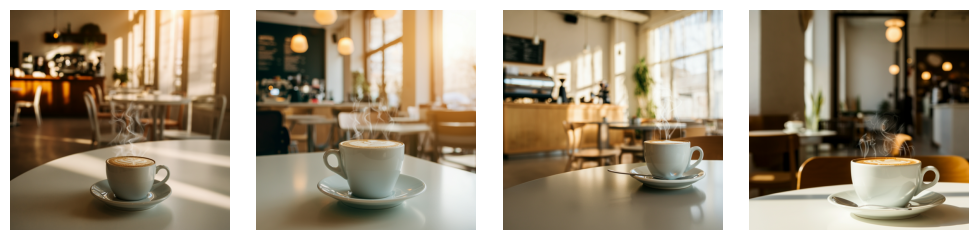

Best image = "gs://lj-globo-demo/generated_image_1.png"
Reason = Image 1 provides the best balance of focus, lighting, and atmosphere.  The coffee is sharply in focus, the latte art is clearly visible, and the warm sunlight streaming through the window creates a welcoming ambiance without being overly bright or distracting. The background blur is effective in drawing the eye to the coffee cup while still showcasing the modern and inviting coffee shop interior.  The other images are either slightly blurry, too dark, or lack the same balance of elements that makes Image 1 visually appealing and commercially effective.



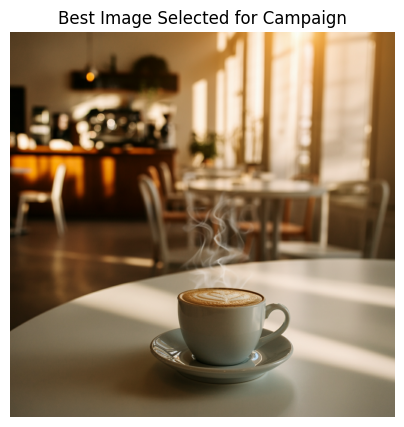

In [19]:
# Generate Image and pick Best image

import gcsfs
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from google.cloud import storage
import vertexai
from vertexai.generative_models import GenerativeModel, Part
from vertexai.preview.vision_models import ImageGenerationModel
import requests
import io
import os

# Reduce gRPC verbosity
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GRPC_TRACE"] = ""  # Disable detailed tracing
# Initialize Vertex AI
PROJECT_ID = "layo-demo"  # Replace with your actual project ID
vertexai.init(project=PROJECT_ID, location="us-central1")

# GCS bucket name
GCS_BUCKET = "lj-globo-demo"

# Directory to store downloaded fonts
FONT_DIR = "fonts"
os.makedirs(FONT_DIR, exist_ok=True)  # Create fonts directory if it doesn't exist

# Function to download fonts from Google Fonts
def download_fonts(font_names):
    for font_name in font_names:
        url = f"https://fonts.googleapis.com/css2?family={font_name.replace(' ', '+')}:ital,wght@0,400;1,400&display=swap"
        response = requests.get(url)
        font_url = [line.split('url(')[1].split(')')[0].replace('"', '').replace('\'', '') 
                    for line in response.text.split('\n') if 'url(' in line]

        for font in font_url:
            font_response = requests.get(font)
            font_file_name = os.path.join(FONT_DIR, f"{font_name.replace(' ', '_').lower()}.ttf")
            with open(font_file_name, 'wb') as font_file:
                font_file.write(font_response.content)

# Specify the fonts you want to download
fonts_to_download = [
    "Helvetica", "Roboto", "Open Sans", "Lato", "Montserrat", "Poppins",
    "Source Sans Pro", "Raleway", "Noto Sans", "Times New Roman", "Georgia",
    "Merriweather", "Playfair Display", "Baskerville", "Crimson Text",
    "Libre Baskerville", "Cardo", "Lora", "PT Serif", "Impact", "Oswald",
    "Bebas Neue", "Lobster", "Pacifico", "Dancing Script", "Abril Fatface",
    "Playful", "Rock Salt", "Satisfy", "Courier New", "Consolas",
    "Source Code Pro", "Roboto Mono", "Fira Code", "Inconsolata", "Menlo",
    "Ubuntu Mono", "PT Mono", "Space Mono", "Patrick Hand", "Quicksand",
    "Sacramento", "Allura", "Bad Script", "Kalam", "Reenie Beanie",
    "Dancing Script", "Caveat", "Fredericka the Great"
]

download_fonts(fonts_to_download)

# Function to upload files to GCS
def upload_to_gcs(local_file_path, bucket_name, destination_blob_name):
    storage_client = storage.Client()
    blob = storage_client.bucket(bucket_name).blob(destination_blob_name)
    blob.upload_from_filename(local_file_path)
    return f"gs://{bucket_name}/{destination_blob_name}"

# Step 1: Generate images using ImageGenerationModel
image_model = ImageGenerationModel.from_pretrained("imagen-3.0-generate-001")

# Example prompt
user_prompt = input("Enter the prompt to create an image, example : 'Create an image for a new coffee shop campaign' ")
text1 = """"Refine the following prompt to generate a high-quality, realistic image. Only display the final prompt:
Prompt: 
{}
The image should be bright, welcoming,very modern ,creative, highly realistic, visually appealing, and of exceptional quality. Image Focus should be on the main ask.""".format(user_prompt)
text =generate(text1)
print("AI Prompt :",text)

# Generate images for a coffee shop campaign
images = image_model.generate_images(
    prompt=text,
    number_of_images=4,
    language="en",
    seed=100,
    add_watermark=False,
    aspect_ratio="1:1",
    safety_filter_level="block_few",
    person_generation="allow_adult",
)

# Save images to local disk and upload to GCS
image_paths = []
gcs_uris = []
for i, img in enumerate(images):
    local_file_path = f"generated_image_{i + 1}.png"
    img.save(local_file_path, include_generation_parameters=False)
    image_paths.append(local_file_path)
    gcs_uri = upload_to_gcs(local_file_path, GCS_BUCKET, os.path.basename(local_file_path))
    gcs_uris.append(gcs_uri)

# Display the generated images
plt.figure(figsize=(10, 2.5))
for i, img_path in enumerate(image_paths):
    img_np = np.array(Image.open(img_path))
    plt.subplot(1, 4, i + 1)
    plt.imshow(img_np)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Step 2: Analyze images using GenerativeModel to select the best one
model = GenerativeModel("gemini-1.5-flash-002")

# Define the prompt for evaluation
prompt = """
Examine the given images to identify the one that best meets the criteria outlined in the prompt {}. The chosen image should be clear and stable, free from any blurriness or shake.
Evaluate aspects like clarity, ambiance, overall feel, and the image's ability to attract customers to the shop.Image should be more focussed on what was requested.
Only select one image and explain briefly why it is the best choice.
'X' in best image can be 1 or 2 or 3 or 4
Output in format as :
    Best image = "gs://lj-globo-demo/generated_image_X.png" 
    Reason = 
""".format(text)

# Create contents list with the images and the prompt
contents = [Part.from_uri(uri, mime_type="image/png") for uri in gcs_uris] + [prompt]

# Generate the response
response = model.generate_content(contents)
print(response.text)

# Step 3: Extract the GCS URL of the best image
best_image_url = None
try:
    if "Best image" in response.text:
        best_image_url = response.text.split("Best image = ")[1].split("\n")[0].strip().strip('"')
except (IndexError, ValueError):
    print("Could not extract the best image GCS URL from the response.")

if best_image_url:

    # Step 4: Download and display the selected best image from the GCS URL
    gcs_parts = best_image_url.split('/')
    bucket_name = gcs_parts[2]
    blob_name = '/'.join(gcs_parts[3:])

    # Download the image
    blob = storage.Client().bucket(bucket_name).blob(blob_name)
    image_data = blob.download_as_bytes()
    best_image_pil = Image.open(io.BytesIO(image_data))

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(np.array(best_image_pil))
    plt.axis('off')
    plt.title("Best Image Selected for Campaign")
    plt.show()
else:
    print("No best image URL found.")


Enter the prompt to create an image, example : 'Create an image for a new coffee shop campaign'  Create an image for a new coffee shop campaign


AI Prompt : Photorealistic image of a bright, modern coffee shop interior, showcasing a steaming cup of coffee on a minimalist table, bathed in warm, natural light.  Focus on the coffee and the inviting atmosphere.



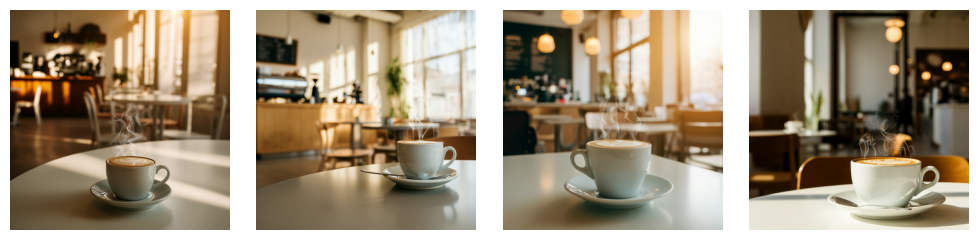

Best image = "gs://lj-globo-demo/generated_image_1.png"
Reason = Image 1 provides the best balance of clarity, ambiance, and focus. The coffee is sharply in focus, the latte art is clearly visible, and the background is softly blurred creating a pleasant bokeh effect that highlights the coffee without distracting from it. The warm sunlight streaming in adds to the inviting atmosphere, making it visually appealing and likely to attract customers. The other images have either less clear focus on the coffee, less appealing lighting, or a less visually pleasing background blur.



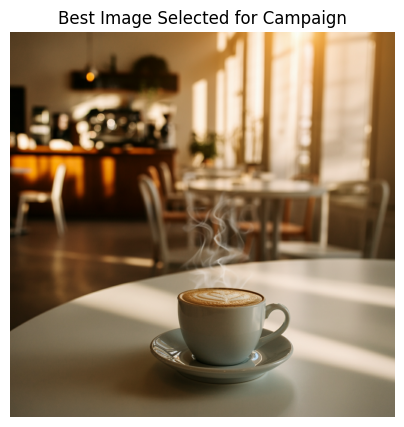

Enter the text you want to display on the image, example : 'Let’s speak over coffee!'  prenons une tasse de café !


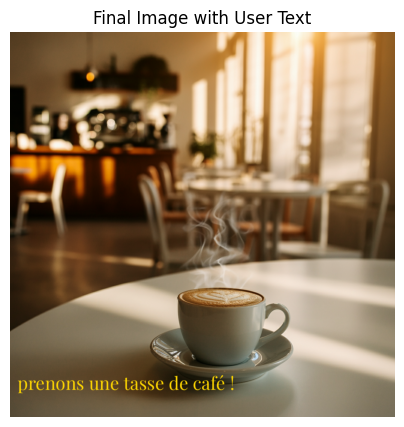

'gs://lj-globo-demo/final_image_with_text.png'

In [20]:
# Generate Image and Pick Best image, Add text on best image

import gcsfs
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from google.cloud import storage
import vertexai
from vertexai.generative_models import GenerativeModel, Part
from vertexai.preview.vision_models import ImageGenerationModel
import requests
import io

# Initialize Vertex AI
PROJECT_ID = "layo-demo"  # Replace with your actual project ID
vertexai.init(project=PROJECT_ID, location="us-central1")

# GCS bucket name
GCS_BUCKET = "lj-globo-demo"

# Directory to store downloaded fonts
FONT_DIR = "fonts"
os.makedirs(FONT_DIR, exist_ok=True)  # Create fonts directory if it doesn't exist

# Function to download fonts from Google Fonts
def download_fonts(font_names):
    for font_name in font_names:
        url = f"https://fonts.googleapis.com/css2?family={font_name.replace(' ', '+')}:ital,wght@0,400;1,400&display=swap"
        response = requests.get(url)
        font_url = [line.split('url(')[1].split(')')[0].replace('"', '').replace('\'', '') 
                    for line in response.text.split('\n') if 'url(' in line]

        for font in font_url:
            font_response = requests.get(font)
            font_file_name = os.path.join(FONT_DIR, f"{font_name.replace(' ', '_').lower()}.ttf")
            with open(font_file_name, 'wb') as font_file:
                font_file.write(font_response.content)

# Specify the fonts you want to download
fonts_to_download = [
    "Helvetica", "Roboto", "Open Sans", "Lato", "Montserrat", "Poppins",
    "Source Sans Pro", "Raleway", "Noto Sans", "Times New Roman", "Georgia",
    "Merriweather", "Playfair Display", "Baskerville", "Crimson Text",
    "Libre Baskerville", "Cardo", "Lora", "PT Serif", "Impact", "Oswald",
    "Bebas Neue", "Lobster", "Pacifico", "Dancing Script", "Abril Fatface",
    "Playful", "Rock Salt", "Satisfy", "Courier New", "Consolas",
    "Source Code Pro", "Roboto Mono", "Fira Code", "Inconsolata", "Menlo",
    "Ubuntu Mono", "PT Mono", "Space Mono", "Patrick Hand", "Quicksand",
    "Sacramento", "Allura", "Bad Script", "Kalam", "Reenie Beanie",
    "Dancing Script", "Caveat", "Fredericka the Great"
]

download_fonts(fonts_to_download)

# Function to upload files to GCS
def upload_to_gcs(local_file_path, bucket_name, destination_blob_name):
    storage_client = storage.Client()
    blob = storage_client.bucket(bucket_name).blob(destination_blob_name)
    blob.upload_from_filename(local_file_path)
    return f"gs://{bucket_name}/{destination_blob_name}"

# Step 1: Generate images using ImageGenerationModel
image_model = ImageGenerationModel.from_pretrained("imagen-3.0-generate-001")

# Example prompt
user_prompt = input("Enter the prompt to create an image, example : 'Create an image for a new coffee shop campaign' ")
text1 = """"Refine the following prompt to generate a high-quality, realistic image. Only display the final prompt:
Prompt: 
{}
The image should be bright, welcoming,very modern ,creative, highly realistic, visually appealing, and of exceptional quality. Image Focus should be on the main ask.""".format(user_prompt)
text =generate(text1)
print("AI Prompt :",text)

# Generate images for a coffee shop campaign
images = image_model.generate_images(
    prompt=text,
    number_of_images=4,
    language="en",
    seed=100,
    add_watermark=False,
    aspect_ratio="1:1",
    safety_filter_level="block_few",
    person_generation="allow_adult",
)

# Save images to local disk and upload to GCS
image_paths = []
gcs_uris = []
for i, img in enumerate(images):
    local_file_path = f"generated_image_{i + 1}.png"
    img.save(local_file_path, include_generation_parameters=False)
    image_paths.append(local_file_path)
    gcs_uri = upload_to_gcs(local_file_path, GCS_BUCKET, os.path.basename(local_file_path))
    gcs_uris.append(gcs_uri)

# Display the generated images
plt.figure(figsize=(10, 2.5))
for i, img_path in enumerate(image_paths):
    img_np = np.array(Image.open(img_path))
    plt.subplot(1, 4, i + 1)
    plt.imshow(img_np)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Step 2: Analyze images using GenerativeModel to select the best one
model = GenerativeModel("gemini-1.5-flash-002")

# Define the prompt for evaluation
prompt = """
Examine the given images to identify the one that best meets the criteria outlined in the prompt {}. The chosen image should be clear and stable, free from any blurriness or shake.
Evaluate aspects like clarity, ambiance, overall feel, and the image's ability to attract customers to the shop.
Only select one image and explain briefly why it is the best choice.
'X' in best image can be 1 or 2 or 3 or 4
Output in format as :
    Best image = "gs://lj-globo-demo/generated_image_X.png" 
    Reason = 
""".format(text)

# Create contents list with the images and the prompt
contents = [Part.from_uri(uri, mime_type="image/png") for uri in gcs_uris] + [prompt]

# Generate the response
response = model.generate_content(contents)
print(response.text)

# Step 3: Extract the GCS URL of the best image
best_image_url = None
try:
    if "Best image" in response.text:
        best_image_url = response.text.split("Best image = ")[1].split("\n")[0].strip().strip('"')
except (IndexError, ValueError):
    print("Could not extract the best image GCS URL from the response.")

if best_image_url:

    # Step 4: Download and display the selected best image from the GCS URL
    gcs_parts = best_image_url.split('/')
    bucket_name = gcs_parts[2]
    blob_name = '/'.join(gcs_parts[3:])

    # Download the image
    blob = storage.Client().bucket(bucket_name).blob(blob_name)
    image_data = blob.download_as_bytes()
    best_image_pil = Image.open(io.BytesIO(image_data))

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(np.array(best_image_pil))
    plt.axis('off')
    plt.title("Best Image Selected for Campaign")
    plt.show()
else:
    print("No best image URL found.")
    
    

# Step 4: Get user input text
user_text = input("Enter the text you want to display on the image, example : 'Let’s speak over coffee!' ")
# Example Images for few shot training
example_images = ["example1.png", "example2.png", "example3.png", "example4.png"]

# Define the prompt for text placement evaluation
placement_prompt = f"""
Analyze the image and determine the best position for the text '{user_text}'. 
Identify the ideal placement that ensures the text is clearly visible, using a large, bold font. 
The text should be placed in a non-busy area of the image, such as at the bottom, left, or right side, where it won't obscure key parts of the image.

Ensure the font style starts with Capital Case (e.g., 'Abcd') and avoid using the 'Arial' font. 
Choose a vibrant text color that fits well with the image, and select a suitable font size. 
pick text_font from the list  only: "Helvetica", "Roboto", "Open Sans", "Lato", "Montserrat", "Poppins",
    "Source Sans Pro", "Raleway", "Noto Sans", "Times New Roman", "Georgia",
    "Merriweather", "Playfair Display", "Baskerville", "Crimson Text",
    "Libre Baskerville", "Cardo", "Lora", "PT Serif", "Impact", "Oswald",
    "Bebas Neue", "Lobster", "Pacifico", "Dancing Script", "Abril Fatface",
    "Playful", "Rock Salt", "Satisfy", "Courier New", "Consolas",
    "Source Code Pro", "Roboto Mono", "Fira Code", "Inconsolata", "Menlo",
    "Ubuntu Mono", "PT Mono", "Space Mono", "Patrick Hand", "Quicksand",
    "Sacramento", "Allura", "Bad Script", "Kalam", "Reenie Beanie",
    "Dancing Script", "Caveat", "Fredericka the Great"
    
Provide the suggested details in JSON format as shown below:

{{
  "text_position": {{
    "x": <<x-coordinate>>,
    "y": <<y-coordinate>>
  }},
  "text_style": "<style>",
  "text_font": "<font>",
  "text_size": <size>,
  "text_color": "<color>"
}}

Otherwise, choose the style that fits best. Refer to the provided example images {', '.join(example_images)} for guidance on font size and spacing.
Carefully examine the image to select a text color that complements and enhances the overall look of the image.
Pick bold oversized text and use a bright contrasting color that stands out in the overall image. Use italics if it fits the image . Choose contrasting color for the text to stand out disctinct in the image.
Ensure the output is only the JSON, with no extra text or formatting.
"""

# Create contents list with the image URL directly and the prompt for text placement
placement_contents = [
    Part.from_uri(best_image_url, mime_type="image/png"),
    placement_prompt
]

# Generate the response for text placement
placement_response = model.generate_content(placement_contents)

# Try to extract the JSON string cleanly
try:
    start = placement_response.text.find('{')
    end = placement_response.text.rfind('}') + 1
    json_str = placement_response.text[start:end]
    placement_json = json.loads(json_str)

    # Process the JSON response
    text_position = placement_json.get("text_position", {"x": 10, "y": 10})
    text_style = placement_json.get("text_style", "normal").lower()
    text_font = placement_json.get("text_font", "Roboto").capitalize()
    text_size = placement_json.get("text_size", 30)
    text_color = placement_json.get("text_color", "#000000")

except (ValueError, KeyError) as e:
    print(f"Error parsing placement response: {e}")

# Step 5: Create the final image with text overlay
final_image = best_image_pil.copy()
draw = ImageDraw.Draw(final_image)

# Replace spaces with underscores in the font name before creating font_path
text_font = text_font.replace(" ", "_")

# Select the font file for the chosen font
font_path = os.path.join(FONT_DIR, f"{text_font.lower()}.ttf")
#print("font_path:",font_path)
try:
    font = ImageFont.truetype(font_path, text_size)
except IOError:
    print(f"Font {text_font} not found. Using default font.")
    font = ImageFont.load_default()

# Set text color and position
text_color = tuple(int(text_color[i:i+2], 16) for i in (1, 3, 5))  # Convert hex to RGB
draw.text((text_position["x"], text_position["y"]), user_text, fill=text_color, font=font)

# Display final image
plt.figure(figsize=(5, 5))
plt.imshow(np.array(final_image))
plt.axis('off')
plt.title("Final Image with User Text")
plt.show()

# Save the final image 
final_image.save("final_image_with_text.png")

# Upload the final image to GCS
upload_to_gcs("final_image_with_text.png", GCS_BUCKET, "final_image_with_text.png")


Enter the prompt to create an image, example : 'Create an image for a new coffee shop campaign'  Create an image for a new coffee shop campaign


AI Prompt : Photorealistic image of a bright, modern coffee shop interior, showcasing a steaming cup of coffee on a minimalist table, bathed in warm, natural light.  Focus on the coffee and the inviting atmosphere.



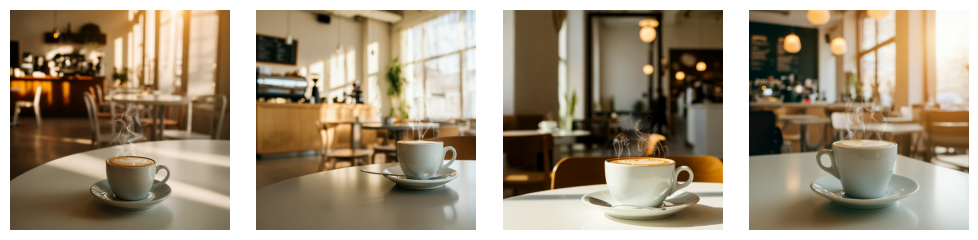

Best image = "gs://lj-globo-demo/generated_image_1.png"
Reason = Image 1 provides the best balance of all the criteria. It has a clear and sharp focus on the coffee, showcasing the latte art and steam effectively. The background is sufficiently blurred to emphasize the coffee without being distracting. The warm, natural light creates a welcoming atmosphere, highlighting the minimalist table and the inviting ambiance of the coffee shop. The overall feel is more refined and aesthetically pleasing than the other images, making it more likely to attract customers.  The other images are slightly less sharp, or have less appealing lighting.



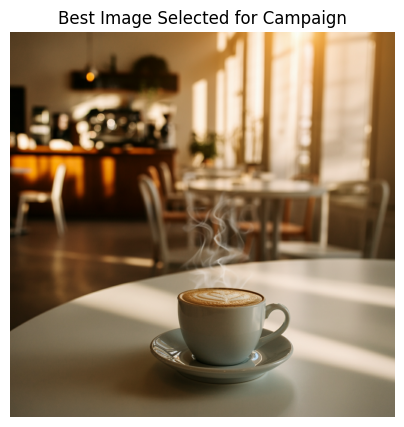

Enter the prompt to create logo, example : 'Create a logo  for 'Layo Cafe’'  Create a logo  for 'Layo Cafe’


Best image = "gs://lj-globo-demo/generated_logo_4.png"
Reason = Image 4 provides the clearest and most visually appealing logo. The neon effect is well-executed and the overall aesthetic is modern and clean.  The addition of coffee cups and ingredients subtly hints at the cafe's offerings without being distracting. The background is simple, allowing the logo to be the focal point.  This image is likely to attract customers due to its stylish and inviting presentation.

Selected best logo GCS URL: gs://lj-globo-demo/generated_logo_4.png


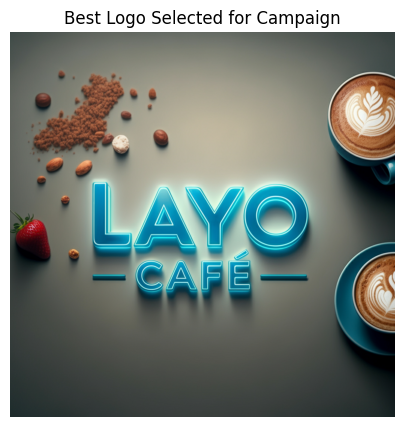

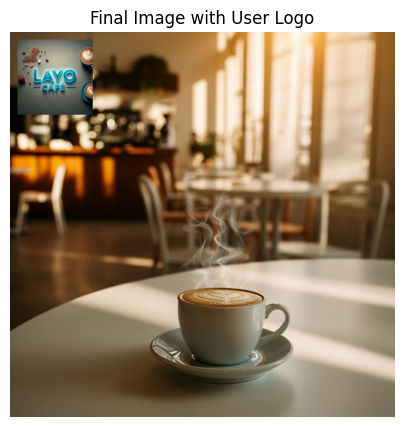

In [24]:
# Create an image, Choose best image, Cretae ogo, Choose Best Logo, add best Logo to the best generated Image

import gcsfs
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from google.cloud import storage
import vertexai
from vertexai.generative_models import GenerativeModel, Part
from vertexai.preview.vision_models import ImageGenerationModel
import requests
import io

# Initialize Vertex AI
PROJECT_ID = "layo-demo"  # Replace with your actual project ID
vertexai.init(project=PROJECT_ID, location="us-central1")

# GCS bucket name
GCS_BUCKET = "lj-globo-demo"

# Function to upload files to GCS
def upload_to_gcs(local_file_path, bucket_name, destination_blob_name):
    storage_client = storage.Client()
    blob = storage_client.bucket(bucket_name).blob(destination_blob_name)
    blob.upload_from_filename(local_file_path)
    #print(f"Uploaded {local_file_path} to gs://{bucket_name}/{destination_blob_name}")
    return f"gs://{bucket_name}/{destination_blob_name}"

# Step 1: Generate images using ImageGenerationModel
image_model = ImageGenerationModel.from_pretrained("imagen-3.0-generate-001")

# Example prompt
# Example prompt
user_prompt = input("Enter the prompt to create an image, example : 'Create an image for a new coffee shop campaign' ")
text1 = """"Refine the following prompt to generate a high-quality, realistic image. Only display the final prompt:
Prompt: 
{}
The image should be bright, welcoming,very modern ,creative, highly realistic, visually appealing, and of exceptional quality. Image Focus should be on the main ask.""".format(user_prompt)
text =generate(text1)
print("AI Prompt :",text)

# Generate images for a coffee shop campaign
images = image_model.generate_images(
    prompt=text,
    number_of_images=4,
    language="en",
    seed=100,
    add_watermark=False,
    aspect_ratio="1:1",
    safety_filter_level="block_few",
    person_generation="allow_adult",
)

# Save images to local disk and upload to GCS
image_paths = []
gcs_uris = []
for i, img in enumerate(images):
    local_file_path = f"generated_image_{i + 1}.png"
    img.save(local_file_path, include_generation_parameters=False)
    image_paths.append(local_file_path)
    gcs_uri = upload_to_gcs(local_file_path, GCS_BUCKET, os.path.basename(local_file_path))
    gcs_uris.append(gcs_uri)

# Display the generated images
plt.figure(figsize=(10, 2.5))
for i, img_path in enumerate(image_paths):
    img_np = np.array(Image.open(img_path))
    plt.subplot(1, 4, i + 1)
    plt.imshow(img_np)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Step 2: Analyze images using GenerativeModel to select the best one
model = GenerativeModel("gemini-1.5-flash-002")

# Define the prompt for evaluation
prompt = """
Examine the given images to identify the one that best meets the criteria outlined in the prompt {}. The chosen image should be clear and stable, free from any blurriness or shake.
Evaluate aspects like clarity, ambiance, overall feel, and the image's ability to attract customers to the shop.
Only select one image and explain briefly why it is the best choice.
'X' in best image can be 1 or 2 or 3 or 4
Output in format as :
    Best image = "gs://lj-globo-demo/generated_image_X.png" 
    Reason = 
""".format(text)

# Create contents list with the images and the prompt
contents = [Part.from_uri(uri, mime_type="image/png") for uri in gcs_uris] + [prompt]

# Generate the response
response = model.generate_content(contents)
print(response.text)

# Step 3: Extract the GCS URL of the best image
best_image_url = None
try:
    if "Best image" in response.text:
        best_image_url = response.text.split("Best image = ")[1].split("\n")[0].strip().strip('"')
except (IndexError, ValueError):
    print("Could not extract the best image GCS URL from the response.")

if best_image_url:

    # Step 4: Download and display the selected best image from the GCS URL
    gcs_parts = best_image_url.split('/')
    bucket_name = gcs_parts[2]
    blob_name = '/'.join(gcs_parts[3:])

    # Download the image
    blob = storage.Client().bucket(bucket_name).blob(blob_name)
    image_data = blob.download_as_bytes()
    best_image_pil = Image.open(io.BytesIO(image_data))

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(np.array(best_image_pil))
    plt.axis('off')
    plt.title("Best Image Selected for Campaign")
    plt.show()
else:
    print("No best image URL found.")
    
# Step 4: Get user input text or logo

logo_prompt = input("Enter the prompt to create logo, example : 'Create a logo  for 'Layo Cafe’' ")
text2 = """Rewrite the below prompt to generate best logo design for a new shop.Display just the one final prompt. 
Create an image with ONLY LOGO focussed on the words for logo. Image should have mild color background to contrast with logo.
Do not include any other words,numbers, images or symbols.
Logo color should be bright blue on lighter background. Fill complete image with the logo only.
Prompt: 
{}

The image should be very realistic and of high quality.The image should be very realistic and of high quality. It should convey its purpose.Be creative and modern.
Include all details.Focus and design on only logo in the image.
""".format(logo_prompt)

text_logo=generate(text2)

# Generate images for logo
images = image_model.generate_images(
    prompt=text_logo,
    number_of_images=4,
    language="en",
    seed=10,
    add_watermark=False,
    aspect_ratio="1:1",
    safety_filter_level="block_few",
    person_generation="allow_adult",
)
# Save images to local disk and upload to GCS
image_paths = []
gcs_uris1 = []
for i, img in enumerate(images):
    local_file_path = f"generated_logo_{i + 1}.png"
    img.save(local_file_path, include_generation_parameters=False)
    image_paths.append(local_file_path)
    gcs_uri1 = upload_to_gcs(local_file_path, GCS_BUCKET, os.path.basename(local_file_path))
    gcs_uris1.append(gcs_uri1)

# Step 2: Analyze images using GenerativeModel to select the best one
model = GenerativeModel("gemini-1.5-flash-002")

# Define the prompt for evaluation
prompt = """
Examine the given images to identify the one that best meets the criteria outlined in the prompt {}. The chosen image should be clear and stable, free from any blurriness or shake.
Evaluate aspects like clarity, ambiance, overall feel, and the image's ability to attract customers to the shop.
Only select one image and explain briefly why it is the best choice.
'X' in best image can be 1 or 2 or 3 or 4
Output in format as :
    Best image = "gs://lj-globo-demo/generated_logo_X.png" 
    Reason = 
""".format(logo_prompt)

# Create contents list with the images and the prompt
contents = [Part.from_uri(uri, mime_type="image/png") for uri in gcs_uris1] + [prompt]

# Generate the response
response = model.generate_content(contents)
print(response.text)

# Step 3: Extract the GCS URL of the best image
logo_file_path = None
try:
    if "Best image" in response.text:
        logo_file_path = response.text.split("Best image = ")[1].split("\n")[0].strip().strip('"')
except (IndexError, ValueError):
    print("Could not extract the best image GCS URL from the response.")

if logo_file_path:
    print(f"Selected best logo GCS URL: {logo_file_path}")

    # Step 4: Download and display the selected best logo from the GCS URL
    gcs_parts = logo_file_path.split('/')
    bucket_name = gcs_parts[2]
    blob_name = '/'.join(gcs_parts[3:])

    # Download the logo image
    logo_blob = storage.Client().bucket(bucket_name).blob(blob_name)
    logo_image_data = logo_blob.download_as_bytes()
    logo_image = Image.open(io.BytesIO(logo_image_data)).convert("RGBA")  # Ensure the logo is in RGBA mode
    
    #Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(np.array(logo_image))
    plt.axis('off')
    plt.title("Best Logo Selected for Campaign")
    plt.show()


    # Define the prompt for logo placement evaluation
    placement_prompt = f"""
    Analyze the best image '{best_image_gcs_url}' and determine the best position for the provided logo image '{logo_file_path}' at any one of the top corners of the image. 
    Ensure the logo is positioned well and does not obscure key parts of the image

    Provide the suggested details in JSON format as shown below:

    {{
      "logo_position": {{
        "x": <<x-coordinate>>,
        "y": <<y-coordinate>>
      }},
      "logo_size": <size>
    }}
    Ensure the output is only the JSON, with no extra text or formatting.
    """

    # Create contents list with the image URL and logo file path for evaluation
    placement_contents = [
        Part.from_uri(best_image_gcs_url, mime_type="image/png"),
        Part.from_uri(logo_file_path, mime_type="image/png"),
        placement_prompt
    ]

    # Generate the response for logo placement
    placement_response = model.generate_content(placement_contents)

    # Print the raw response for debugging
    # print("Raw placement response:", placement_response.text)

    # Try to extract the JSON string cleanly
    try:
        start = placement_response.text.find('{')
        end = placement_response.text.rfind('}') + 1
        json_str = placement_response.text[start:end]
        placement_json = json.loads(json_str)

        # Process the JSON response
        logo_position = placement_json.get("logo_position", {"x": 5, "y": 5})
        logo_size = placement_json.get("logo_size", 50)

        # Resize the logo to the suggested size
        logo_image = logo_image.resize((logo_size, logo_size), Image.LANCZOS)

        # Create a copy of the best image to add the logo
        final_image = best_image_pil.copy()

        # Get the suggested position from the response
        position = (logo_position["x"], logo_position["y"])

        # Paste the logo onto the final image with transparency if supported
        final_image.paste(logo_image, position, logo_image if logo_image.mode == 'RGBA' else None)
        #print(f"Logo added at position {position} with size {logo_size}px")

        # Display final image
        plt.figure(figsize=(5, 5))
        plt.imshow(np.array(final_image))
        plt.axis('off')
        plt.title("Final Image with User Logo")
        plt.show()

        # Save and upload the final image to GCS
        final_image_path = "final_image_with_generatedlogo.png"
        final_image.save(final_image_path)
        upload_to_gcs(final_image_path, 'lj-globo-demo', "final_image_with_generatedlogo.png")

    except json.JSONDecodeError:
        print("Error decoding JSON response for logo placement.")